In [95]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [96]:
cd

/root


In [97]:
cd ../content/drive/MyDrive/FINA4350/FOMC/

/content/drive/.shortcut-targets-by-id/1jWSL-7-Ar9s84ZTFZlpGEpDQOBrS9Dcu/FINA4350/FOMC


## Loading the Governor's Speeches over the years 1996-2020


In [98]:
import pickle
f = open('governor_speech_keyword.pickle', 'rb')   
gdict = pickle.load(f)        
f.close()  
gdict 

,type,date,title,speaker,word_count,text
0,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,896,"Economic theory, in the form of the long-run n..."
1,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,470,"But, even those businesses which do not become..."
2,speech,1996-10-09,Here we go again?,Governor Lawrence B. Lindsey,470,Without any question the most important econom...
3,speech,1996-10-11,How to grow faster,Governor Lawrence B. Lindsey,544,"There is, however, one option that from time i..."
4,speech,1997-01-05,The role of structural macroeconomic models,Governor Laurence H. Meyer,1230,There are two important differences from the p...
...,...,...,...,...,...,...
358,speech,2020-01-16,The Outlook for Housing,Governor Michelle W. Bowman,675,Few sectors are as central to the success of o...
359,speech,2020-02-10,Empowering Community Banks,Governor Michelle W. Bowman,138,My colleagues and I on the Federal Open Market...
360,speech,2020-02-21,Monetary Policy Strategies and Tools When Infl...,Governor Lael Brainard,675,Looking AheadThe current generation of central...
361,speech,2020-07-14,Navigating Monetary Policy through the Fog of ...,Governor Lael Brainard,395,"Finally, in keeping with the global nature of ..."


## Loading the Libraries used in this Project

In [99]:
import nltk
from textblob import TextBlob


In [100]:
import pandas as pd
import os
import re
import unicodedata
from time import gmtime, strftime
from datetime import datetime, timedelta


import warnings
warnings.filterwarnings("ignore")

# Importing libraries you need to install
import requests
from lxml import html
import bs4 as bs
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import TfidfModel, LdaMulticore
from wordcloud import WordCloud
from datetime import datetime
from collections import Counter
import seaborn as sns
from textblob import TextBlob
import pandas_datareader.data as web


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the FED Interest Rate 
over the years 1996-2020 for analysing the trend

In [101]:
rate = pd.read_csv("united-states.fed-interest-rate-decision.csv",sep='\t') 
rate = rate.drop("ForecastValue", axis = 1)
rate["ChangefromPreviousMeeting"] = rate["ActualValue"] - rate["PreviousValue"]

In [102]:
def lemmetize(words):
    lemmatized_words = [WordNetLemmatizer().lemmatize(w.lower()) for w in words]
    return lemmatized_words

# Formatting the Data

In [103]:
gdict.text = gdict.text.str.replace('\[SECTION\]',' ')
gdict.text = gdict.text.str.replace('\\','')
gdict = gdict.reset_index(drop=True)
gdict

,type,date,title,speaker,word_count,text
0,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,896,"Economic theory, in the form of the long-run n..."
1,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,470,"But, even those businesses which do not become..."
2,speech,1996-10-09,Here we go again?,Governor Lawrence B. Lindsey,470,Without any question the most important econom...
3,speech,1996-10-11,How to grow faster,Governor Lawrence B. Lindsey,544,"There is, however, one option that from time i..."
4,speech,1997-01-05,The role of structural macroeconomic models,Governor Laurence H. Meyer,1230,There are two important differences from the p...
...,...,...,...,...,...,...
358,speech,2020-01-16,The Outlook for Housing,Governor Michelle W. Bowman,675,Few sectors are as central to the success of o...
359,speech,2020-02-10,Empowering Community Banks,Governor Michelle W. Bowman,138,My colleagues and I on the Federal Open Market...
360,speech,2020-02-21,Monetary Policy Strategies and Tools When Infl...,Governor Lael Brainard,675,Looking AheadThe current generation of central...
361,speech,2020-07-14,Navigating Monetary Policy through the Fog of ...,Governor Lael Brainard,395,"Finally, in keeping with the global nature of ..."


## Creating a Financial Dictionary based on Loughran and McDonald Word List

In [104]:
import re

# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', "sustainable", 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [105]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False


In [106]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [107]:
temp = [tone_count_with_negation_check(lmdict,x) for x in gdict.text]
temp = pd.DataFrame(temp)

gdict['wordcount'] = temp.iloc[:,0].values
gdict['NPositiveWords'] = temp.iloc[:,1].values
gdict['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
gdict['sentiment'] = (gdict['NPositiveWords'] - gdict['NNegativeWords']) / gdict['wordcount'] * 100

gdict['Poswords'] = temp.iloc[:,3].values
gdict['Negwords'] = temp.iloc[:,4].values

In [108]:
gdict['index'] = range(0, len(gdict))

gdict.set_index('date', inplace=True)
gdict.head()

,type,title,speaker,word_count,text,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords,index
date,,,,,,,,,,,,
1996-09-08,speech,Monetary policy objectives and strategy,Governor Laurence H. Meyer,896,"Economic theory, in the form of the long-run n...",896,32,35,-0.334821,"[growth, growth, easy, more, growth, higher, s...","[stops, deficit, overstate, challenging, quest...",0
1996-10-02,speech,Small business is big business,Governor Lawrence B. Lindsey,470,"But, even those businesses which do not become...",470,11,7,0.851064,"[better, more, larger, most, up, vibrant, enjo...","[staggering, lost, recession, lost, diminished...",1
1996-10-09,speech,Here we go again?,Governor Lawrence B. Lindsey,470,Without any question the most important econom...,470,9,22,-2.765957,"[most, innovations, increased, opportunity, mo...","[question, decline, decline, declined, fallen,...",2
1996-10-11,speech,How to grow faster,Governor Lawrence B. Lindsey,544,"There is, however, one option that from time i...",544,17,16,0.183824,"[high, growing, more, stable, most, benefit, s...","[shortage, improved (with negation), nonproduc...",3
1997-01-05,speech,The role of structural macroeconomic models,Governor Laurence H. Meyer,1230,There are two important differences from the p...,1230,20,21,-0.081301,"[strong, achieve, more, more, rise, increase, ...","[least, strong, forcing, confront, complicated...",4


## Sentiment Analysis Plots

### Positive and Negative word counts

1996 2021


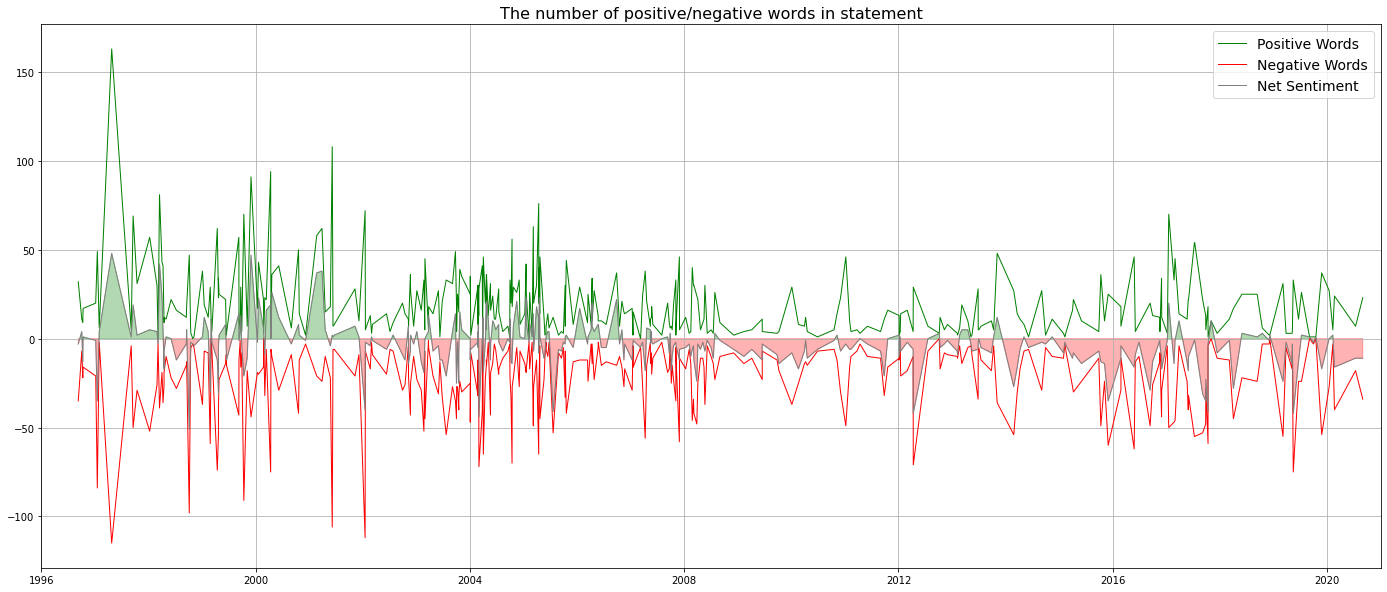

<Figure size 7200x7200 with 0 Axes>

In [109]:
NetSentiment = gdict['NPositiveWords'] - gdict['NNegativeWords']

fig, ax = plt.subplots(figsize=(24,10))

plt.plot(gdict.index, gdict['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(gdict.index, gdict['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(gdict.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)
plt.figure(figsize=(100,100))


ax.fill_between(gdict.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3,
                 interpolate=True)
ax.fill_between(gdict.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3,
                 interpolate=True)



# ## format the ticks
# # round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(gdict.index[0], 'Y')

datemax = np.datetime64(gdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
print(datemin,datemax)

# # format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()

### Net Sentiment Plot

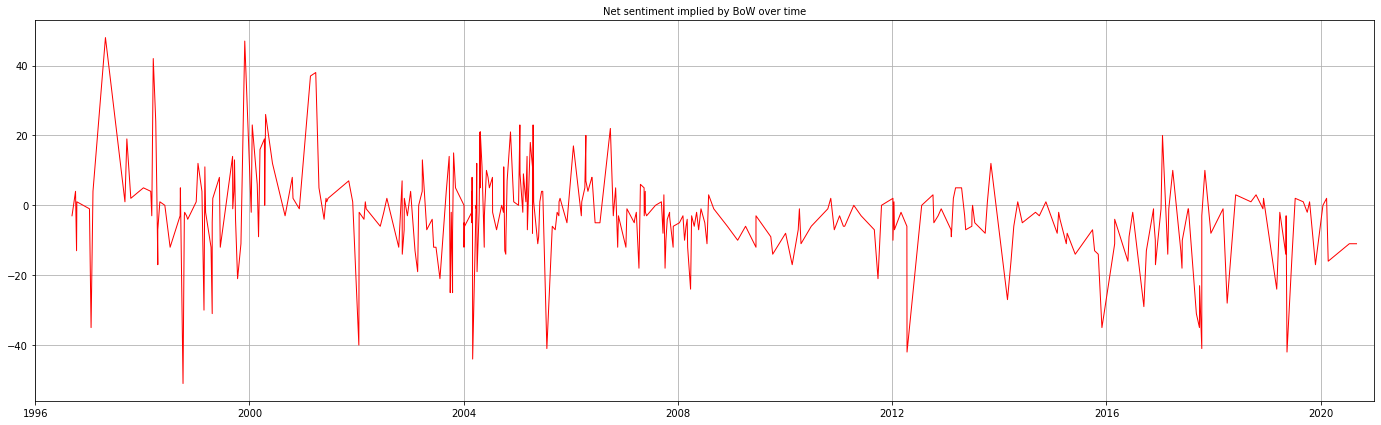

In [110]:
NetSentiment = gdict['NPositiveWords'] - gdict['NNegativeWords']

fig, ax = plt.subplots(figsize=(24,7))

ax.plot(gdict.index, NetSentiment, 
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(gdict.index[0], 'Y')
datemax = np.datetime64(gdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

### Changes in Net Sentiment
using first derivative

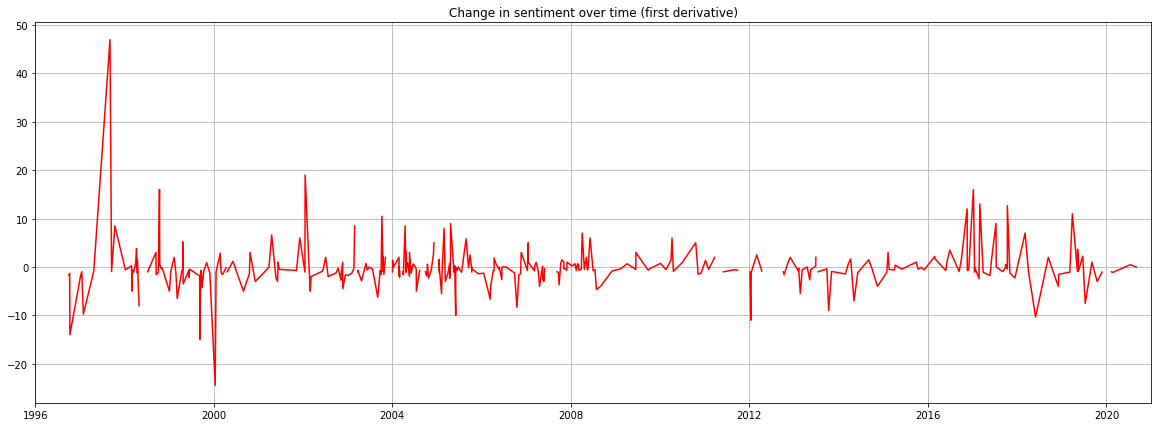

In [111]:
firstderivative = (NetSentiment.shift(1) - NetSentiment) / NetSentiment

fig, ax = plt.subplots(figsize=(20,7))

ax.plot(gdict.index, firstderivative, 
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.
datemin = np.datetime64(gdict.index[0], 'Y')
datemax = np.datetime64(gdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

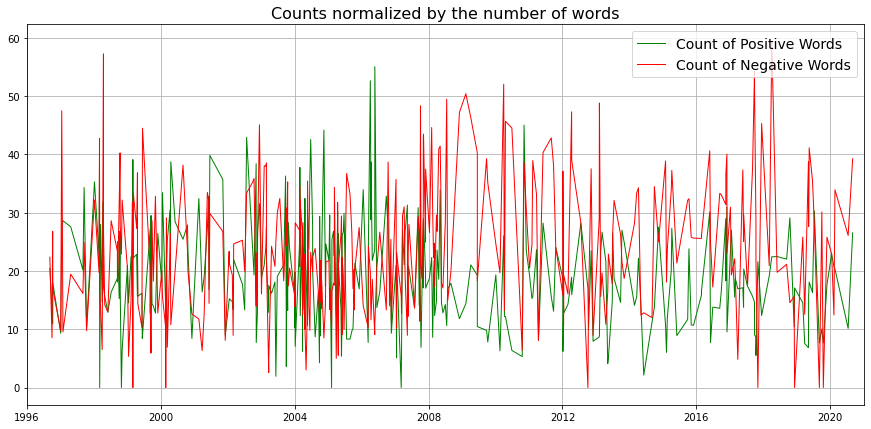

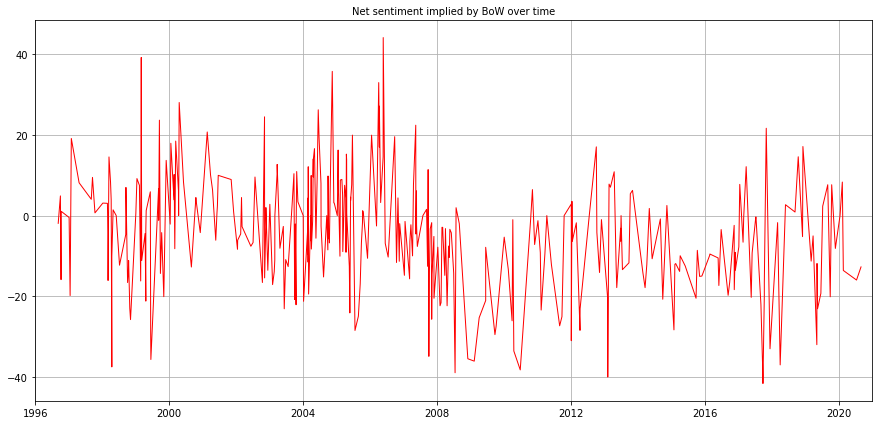

In [112]:
# Normalize data
NPositiveWordsNorm = gdict['NPositiveWords'] / gdict['wordcount'] * np.mean(gdict['wordcount'])
NNegativeWordsNorm = gdict['NNegativeWords'] / gdict['wordcount'] * np.mean(gdict['wordcount'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(gdict.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(gdict.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(gdict.index[0], 'Y')
datemax = np.datetime64(gdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


fig, ax = plt.subplots(figsize=(15,7))
ax.plot(gdict.index, NetSentimentNorm, c='red', linewidth=1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(gdict.index[0], 'Y')
datemax = np.datetime64(gdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

## Function for extracting the direction of the rate change (hike, keep, lower)

Gets Basis Points Move and End Rate Value for Fed Rate and Discount Rate as well as Preferred Fed Rate Move from Statement Text

In [113]:
import nltk.data
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def ExtractKeyValues(text):
    
    '''
    First, the text is tokenized in to sentences and the fed funds target rate sentence is extracted 
    Secondly, the decision whether the fed target rate was hiked, kept or lowered is retreived to RateHike variable
    Third, the target rate range is extracted and saved in TargetRange (The max is extracted as it conveys most info)
    '''
    
    Potentials = [] #For storing the potential decision sentences
        
    #Remove the \n and replace them with dots 
    text = text.replace('\\n','. ')
       
    #Split the text in to a list of sentences
    paragraph_sentence_list = tokenizer.tokenize(text)
    #print('paragraph_sentence_list: ', paragraph_sentence_list)
        
    #Finds the sentences with the decisions 
    for Sentence in paragraph_sentence_list:
        
        #print('Sentence: ', Sentence)
        #Make the text lower case
        Sentence = Sentence.lower()

        if 'federal funds ' in Sentence and  'target' in Sentence:
            
            #Check if it contains a number
            if bool(re.search(r'\d', Sentence)):
                
                Potentials.append(Sentence)
        
    Potentials = ''.join(Potentials)
    #print('Potentials: ', Potentials)

    
    #Look for decision words related to raising rates
    r = Potentials.find('rais')
    i = Potentials.find('increas')
    upscore = max([r,i])
    
    #Look for decision words related to keeping rates
    k = Potentials.find('keep')
    m = Potentials.find('maintain')
    r = Potentials.find('remain')
    c = Potentials.find('current')
    keepscore = max([r,k,m,c])
    
    #Look for decision words related to decreasing rates
    l = Potentials.find('lower')
    d = Potentials.find('decreas')
    lowerscore = max([l,d])
    
    Summary = {1:upscore,
              0: keepscore,
              -1:lowerscore
              }
        
    #take the key that was mentioned first in the text
    RateHike = max(Summary.keys(), key=(lambda x: Summary[x]))

    #For extracting the target range 
    def RangeReader(Nums):
        
        def FractionReader(Fraction):
            
            '''
            Converts the fraction to a float
            ''' 
            i = 0
            if '/' in Fraction:
                if ' ' in Fraction:
                    i, Fraction = Fraction.split(' ')
                if '-' in Fraction:
                    i, Fraction = Fraction.split('-')
                if '‑' in Fraction:
                    i, Fraction = Fraction.split('‑')
                N, D = Fraction.split('/')
                return float(i) + float(N) / float(D)
            
            else:
                return float(i)+float(Fraction)
        
        #Splits the range based on to or -
        Splitters = [' to ','-']
        
        for Splitter in Splitters:
            if Splitter in Nums:
                TargetRange = Nums.split(Splitter)
                return FractionReader(TargetRange[0]), FractionReader(TargetRange[1])
        
        #If there was no splitter in the range (no range)
        return FractionReader(Nums)
        
        
    #Find the percentage change and take the closest digits
    Rate = Potentials[ : Potentials.find('percent') -1 ]
    Rate = Rate[-16:]
    # print(Rate)
    if re.search("\d", Rate):
        Rate = Rate[ re.search("\d", Rate).start() : ]
        TargetRange = np.max(RangeReader(Rate))
    else:
        Rate = None
        TargetRange = None
      
    return RateHike, TargetRange

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [114]:
cd

/root


In [115]:
cd ../content/drive/MyDrive/FINA4350/centralbank_analysis-master/data/MarketData/Quandl/

/content/drive/.shortcut-targets-by-id/1jWSL-7-Ar9s84ZTFZlpGEpDQOBrS9Dcu/FINA4350/centralbank_analysis-master/data/MarketData/Quandl


## FED Rates over the years

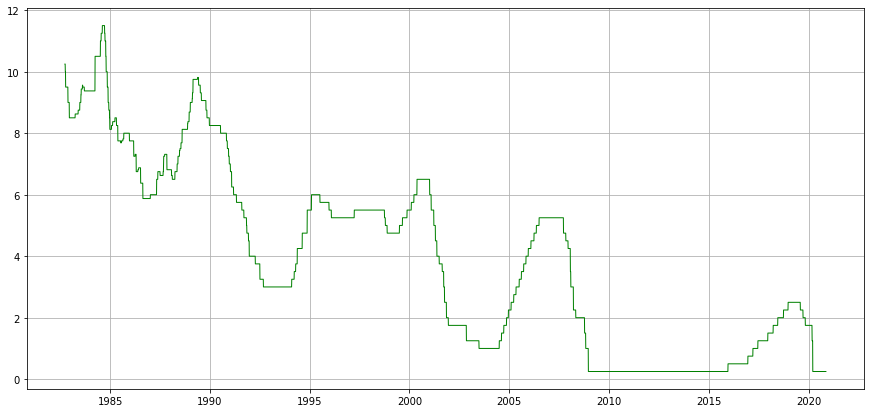

In [116]:
filename_till08 = 'FRED_DFEDTAR.csv'
filename_from08u = 'FRED_DFEDTARU.csv'
filename_from08l = 'FRED_DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()




# Correlation Between FED Rates and Governor Speeches Sentiment

In [117]:
gdict['RateDecision'] = None
gdict['Rate'] = None

for i in range(len(gdict)):
    for j in range(len(fedrate_df)):
        if gdict.index[i] == fedrate_df.index[j]:
            gdict['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                gdict['RateDecision'][i] = 0
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                gdict['RateDecision'][i] = 1
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                gdict['RateDecision'][i] = -1

In [118]:
def pickle_dump(df, filename='no-filename.pickle'):
    if filename:
        with open(filename, "wb") as output_file:
            pickle.dump(df, output_file)


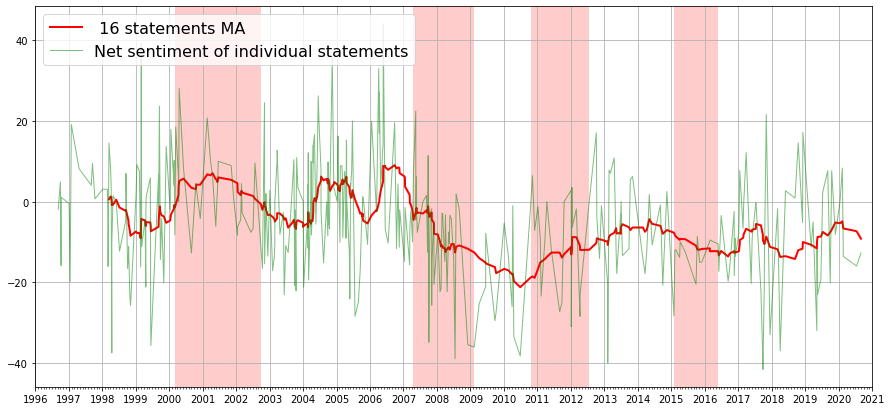

In [119]:
#Dot-com bubble
#https://en.wikipedia.org/wiki/Dot-com_bubble
DotCom = np.logical_and(gdict.index > '2000-03',
                         gdict.index < '2002-10'
                        )

#Financial crisis of 2007–2008
#https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
OhEight = np.logical_and(gdict.index > '2007-04',
                         gdict.index < '2009-03'
                        )

#European debt crisis
#https://en.wikipedia.org/wiki/European_debt_crisis
EuroDebt = np.logical_and(gdict.index > '2010-09',
                          gdict.index < '2012-09'
                          )

#2015–16 Chinese stock market turbulence
#https://en.wikipedia.org/wiki/2015%E2%80%9316_Chinese_stock_market_turbulence
Asian = np.logical_and(gdict.index > '2015-01',
                       gdict.index < '2016-06'
                       )


Recessions = np.logical_or.reduce( ( DotCom,
                                     OhEight,
                                     EuroDebt,
                                     Asian 
                                    )
                                 )

Window = 16
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(gdict.index,
         CompToMA,
         c = 'r',
         linewidth= 2)

ax.plot(gdict.index, NetSentimentNorm, 
         c = 'green',
         linewidth= 1,
         alpha = 0.5)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(gdict.index[0], 'Y')
datemax = np.datetime64(gdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)



#plt.title( str('Moving average of last ' + str(Window) + ' statements (~2 Year Window) seems to match with periods of economic uncertainty / systemic risk:'))

ax.legend([str( ' 16 statements MA'), 'Net sentiment of individual statements'],
           prop={'size': 16},
           loc = 2
          )

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(gdict.index, 0, 10, where = Recessions,
                facecolor='red', alpha=0.2, transform=trans)

plt.show()

In [120]:
Powell=np.logical_and(gdict.index> '2013-02-21' ,gdict.index< '2017-11-02') 
Duke=np.logical_and(gdict.index>' 2009-02-11 ',gdict.index< '2013-05-09' )
Mishkin =np.logical_and(gdict.index>'2007-01-17' ,gdict.index< '2008-07-28') 
Kohn =np.logical_and(gdict.index>'2002-11-22' ,gdict.index< '2006-04-27' )
Kroszner=np.logical_and(gdict.index> '2006-04-06 ',gdict.index< '2008-12-03 ')
Brainard=np.logical_and(gdict.index> '2015-04-02',gdict.index< ' 2020-09-01') 
Warsh=np.logical_and(gdict.index> '2006-07-18'  ,gdict.index<'2010-11-08' )
Gramlich =np.logical_and(gdict.index>'1998-02-27' ,gdict.index< '2005-06-03' )
Olson=np.logical_and(gdict.index> '2002-07-26',gdict.index< '2006-05-25')
# Raskin= 2011-02-11  2013-07-17 
# BernankeReinhart=2004-01-03  2004-01-03
Lindsey=np.logical_and(gdict.index> '1996-10-02',gdict.index<' 1996-10-11' )
Bowman= np.logical_and(gdict.index>'2019-03-28' ,gdict.index< '2020-02-10' )
Kelley= np.logical_and(gdict.index>'1997-01-29',gdict.index< ' 1998-10-29') 
Stein=np.logical_and(gdict.index> '2012-10-11',gdict.index<  '2014-05-06')
Meyer =np.logical_and(gdict.index>'1996-09-08' ,gdict.index<'2002-01-16')
Tarullo=np.logical_and(gdict.index>' 2009-10-08',gdict.index<'2015-09-28')
Bies=np.logical_and(gdict.index> '2003-02-27',gdict.index< '2007-01-18' )
Ferguson=np.logical_and(gdict.index>'1998-03-04',gdict.index<'1999-09-28')



# Greenspan = np.logical_and(cdict.index > '1987-08-11',
#                          cdict.index < '2006-01-31'
#                         )

# Bernanke = np.logical_and(cdict.index > '2006-02-01',
#                          cdict.index < '2014-01-31'
#                         )

# Yellen = np.logical_and(cdict.index > '2014-02-03',
#                           cdict.index < '2018-02-03'
#                           )

# Powell = np.logical_and(cdict.index > '2018-02-05',
#                        cdict.index < '2022-02-05'
#                        )

Speaker = np.logical_or.reduce((Ferguson, Powell))

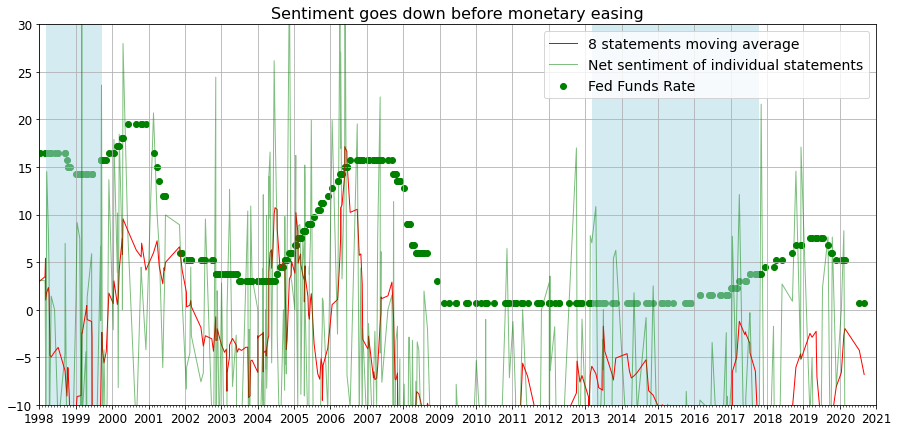

In [121]:
Window = 8
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(gdict.index, 
            gdict['Rate']*3, 
            c = 'g')

ax.plot(gdict.index,
         CompToMA,
         c = 'r',
         linewidth= 1.0)

ax.plot(gdict.index, NetSentimentNorm, 
         c = 'green',
         linewidth= 1,
         alpha = 0.5)

ax.legend([str(str(Window) + ' statements moving average') , 'Net sentiment of individual statements', 'Fed Funds Rate'],
           prop={'size': 14},
           loc = 1
           )

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(gdict.index[18], 'Y')
datemax = np.datetime64(gdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.set_ylim(-10,30)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=12)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(gdict.index, 0, 10, where = Speaker,
                facecolor='lightblue', alpha=0.5, transform=trans)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# ax.text(0.13, 0.75, "Alan Greenspan", transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
# ax.text(0.46, 0.75, "Ben Bernanke", transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
# ax.text(0.73, 0.75, "Janet Yellen", transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)
# ax.text(0.88, 0.75, "Jerome Powell", transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

arrow_style = dict(facecolor='black', edgecolor='white', shrink=0.05)

plt.title('Sentiment goes down before monetary easing', fontsize=16)

plt.show()

In [122]:
cd

/root


In [123]:
cd ../content/drive/MyDrive/FINA4350/FOMC

/content/drive/.shortcut-targets-by-id/1jWSL-7-Ar9s84ZTFZlpGEpDQOBrS9Dcu/FINA4350/FOMC


In [124]:
cd FOMC

[Errno 2] No such file or directory: 'FOMC'
/content/drive/.shortcut-targets-by-id/1jWSL-7-Ar9s84ZTFZlpGEpDQOBrS9Dcu/FINA4350/FOMC


# Speeches of FED Chairs and Correlation with FED Interest Rate Decision

Repeating same process for Chair Speeches

In [125]:
import pickle
f = open('chairman_speech_keyword.pickle', 'rb')   
cdict = pickle.load(f)        
f.close()  
cdict 

,type,date,title,speaker,word_count,text
0,speech,1996-10-05,"Bank supervision, regulation, and risk",Chairman Alan Greenspan,136,"While awaiting perfection, it is useful to und..."
1,speech,1996-12-06,Social security,Chairman Alan Greenspan,253,While such evaluations are based on an uncerta...
2,speech,1997-01-14,Central banking and global finance,Chairman Alan Greenspan,133,"In theory, the allocation of responsibility fo..."
3,speech,1997-02-21,Government regulation and derivative contracts,Chairman Alan Greenspan,212,In the case of the institutional off-exchange ...
4,speech,1997-04-29,G-7 economic summit meeting,Chairman Alan Greenspan,142,"In theory, the allocation of responsibility fo..."
...,...,...,...,...,...,...
177,speech,2018-09-27,Brief Remarks on the U.S. Economy,Chairman Jerome H. Powell,129,"Each time we meet, we face the same question: ..."
178,speech,2018-10-02,Monetary Policy and Risk Management at a Time ...,Chairman Jerome H. Powell,615,Today I will focus on the Federal Reserves ong...
179,speech,2018-11-28,The Federal Reserve's Framework for Monitoring...,Chairman Jerome H. Powell,320,Outlook and Monetary PolicyCongress assigned t...
180,speech,2018-12-06,Welcoming Remarks,Chairman Jerome H. Powell,220,I am happy to report that our economy is curre...


In [126]:
cdict.text = cdict.text.str.replace('\[SECTION\]',' ')
cdict.text = cdict.text.str.replace('\\','')
cdict = cdict.reset_index(drop=True)
# speech = speech.drop('index',axis=1)
cdict

,type,date,title,speaker,word_count,text
0,speech,1996-10-05,"Bank supervision, regulation, and risk",Chairman Alan Greenspan,136,"While awaiting perfection, it is useful to und..."
1,speech,1996-12-06,Social security,Chairman Alan Greenspan,253,While such evaluations are based on an uncerta...
2,speech,1997-01-14,Central banking and global finance,Chairman Alan Greenspan,133,"In theory, the allocation of responsibility fo..."
3,speech,1997-02-21,Government regulation and derivative contracts,Chairman Alan Greenspan,212,In the case of the institutional off-exchange ...
4,speech,1997-04-29,G-7 economic summit meeting,Chairman Alan Greenspan,142,"In theory, the allocation of responsibility fo..."
...,...,...,...,...,...,...
177,speech,2018-09-27,Brief Remarks on the U.S. Economy,Chairman Jerome H. Powell,129,"Each time we meet, we face the same question: ..."
178,speech,2018-10-02,Monetary Policy and Risk Management at a Time ...,Chairman Jerome H. Powell,615,Today I will focus on the Federal Reserves ong...
179,speech,2018-11-28,The Federal Reserve's Framework for Monitoring...,Chairman Jerome H. Powell,320,Outlook and Monetary PolicyCongress assigned t...
180,speech,2018-12-06,Welcoming Remarks,Chairman Jerome H. Powell,220,I am happy to report that our economy is curre...


In [127]:
temp = [tone_count_with_negation_check(lmdict,x) for x in cdict.text]
temp = pd.DataFrame(temp)

cdict['wordcount'] = temp.iloc[:,0].values
cdict['NPositiveWords'] = temp.iloc[:,1].values
cdict['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
cdict['sentiment'] = (cdict['NPositiveWords'] - cdict['NNegativeWords']) / cdict['wordcount'] * 100

cdict['Poswords'] = temp.iloc[:,3].values
cdict['Negwords'] = temp.iloc[:,4].values

In [128]:
cdict['index'] = range(0, len(cdict))

cdict.set_index('date', inplace=True)
cdict.head()

,type,title,speaker,word_count,text,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords,index
date,,,,,,,,,,,,
1996-10-05,speech,"Bank supervision, regulation, and risk",Chairman Alan Greenspan,136,"While awaiting perfection, it is useful to und...",136,7,5,1.470588,"[best, assure, best, best, improved, increase,...","[risk, confines, barrier, risk, risk]",0
1996-12-06,speech,Social security,Chairman Alan Greenspan,253,While such evaluations are based on an uncerta...,253,6,6,0.000000,"[benefit, more, increasing, improve, growth, i...","[uncertain, under, less, difficult, down, incr...",1
1997-01-14,speech,Central banking and global finance,Chairman Alan Greenspan,133,"In theory, the allocation of responsibility fo...",133,2,9,-5.263158,"[higher, increased]","[risk, least, risk, risk, risk, smaller, losse...",2
1997-02-21,speech,Government regulation and derivative contracts,Chairman Alan Greenspan,212,In the case of the institutional off-exchange ...,212,5,6,-0.471698,"[efficiently, achieving, deliver, successful, ...","[manipulated, difficult, manipulate, failing, ...",3
1997-04-29,speech,G-7 economic summit meeting,Chairman Alan Greenspan,142,"In theory, the allocation of responsibility fo...",142,5,9,-2.816901,"[greater, higher, more, largest, increased]","[risk, least, risk, risk, risk, smaller, losse...",4


## Sentiment Plots

### Positive and Negative Words Plot

1996 2020


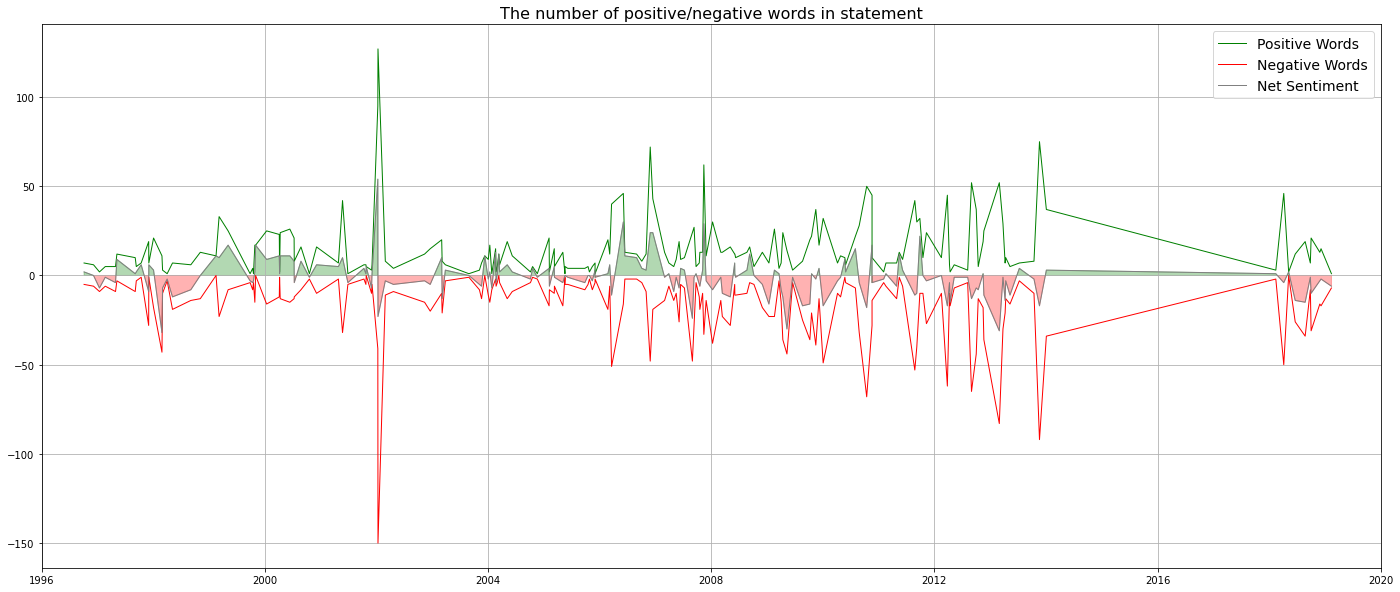

<Figure size 7200x7200 with 0 Axes>

In [129]:
NetSentiment = cdict['NPositiveWords'] - cdict['NNegativeWords']

fig, ax = plt.subplots(figsize=(24,10))

plt.plot(cdict.index, cdict['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(cdict.index, cdict['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(cdict.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)
plt.figure(figsize=(100,100))


ax.fill_between(cdict.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3,
                 interpolate=True)
ax.fill_between(cdict.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3,
                 interpolate=True)



# ## format the ticks
# # round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(cdict.index[0], 'Y')

datemax = np.datetime64(cdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
print(datemin,datemax)

# # format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()

### Net Sentiment Plot

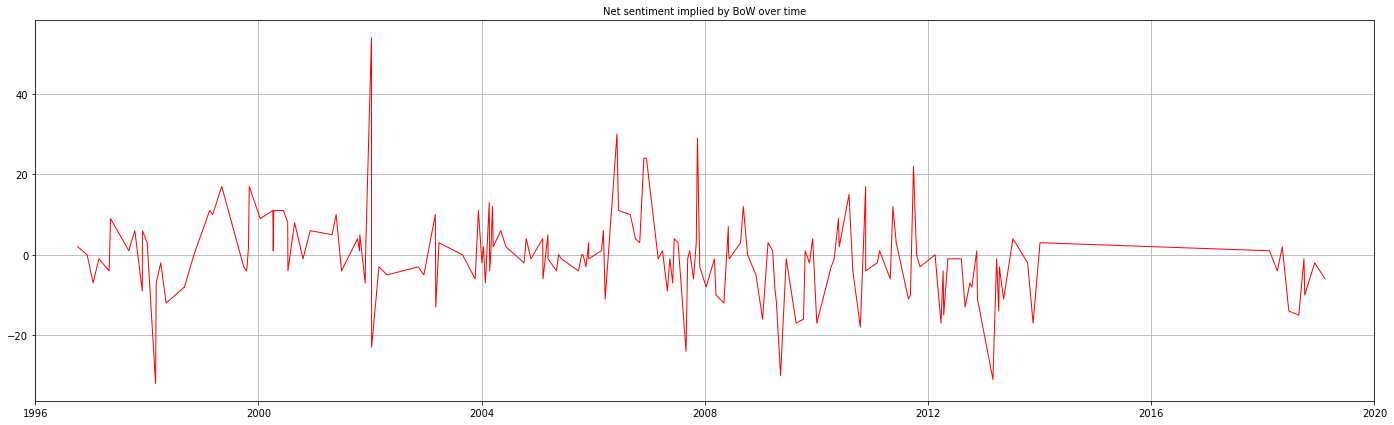

In [130]:
NetSentiment = cdict['NPositiveWords'] - cdict['NNegativeWords']

fig, ax = plt.subplots(figsize=(24,7))

ax.plot(cdict.index, NetSentiment, 
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(cdict.index[0], 'Y')
datemax = np.datetime64(cdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

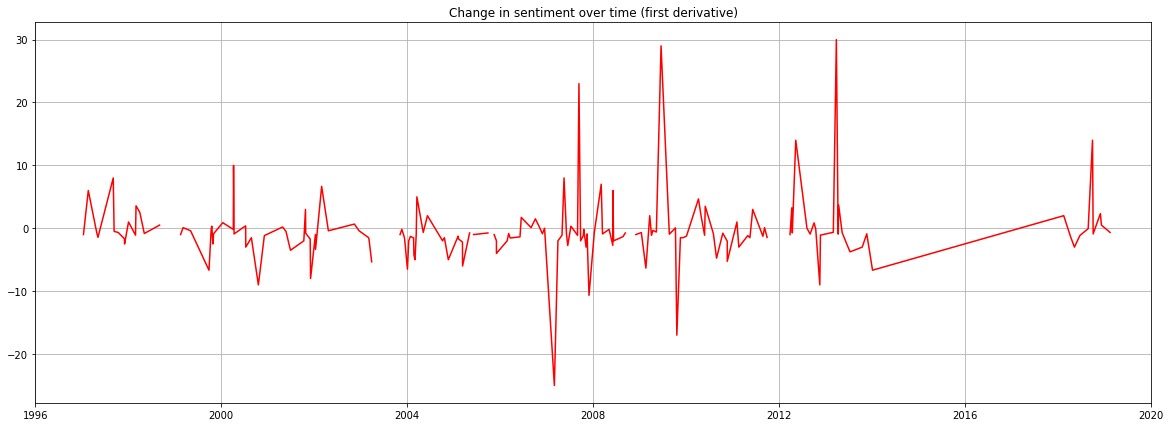

In [131]:
firstderivative = (NetSentiment.shift(1) - NetSentiment) / NetSentiment

fig, ax = plt.subplots(figsize=(20,7))

ax.plot(cdict.index, firstderivative, 
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.
datemin = np.datetime64(cdict.index[0], 'Y')
datemax = np.datetime64(cdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

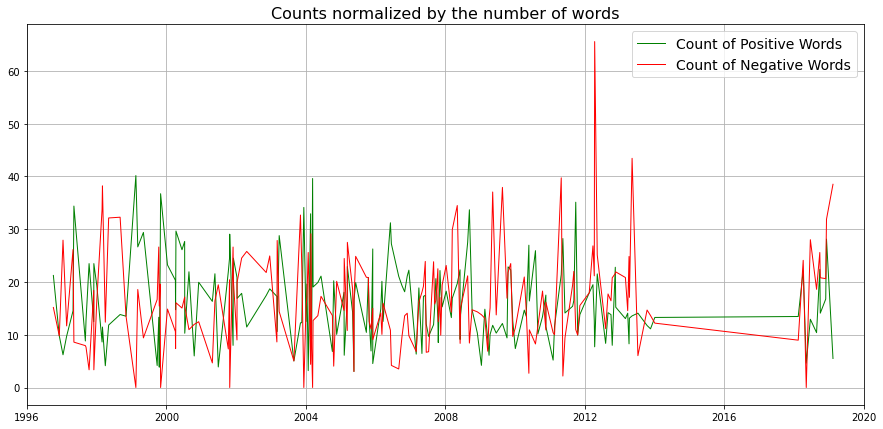

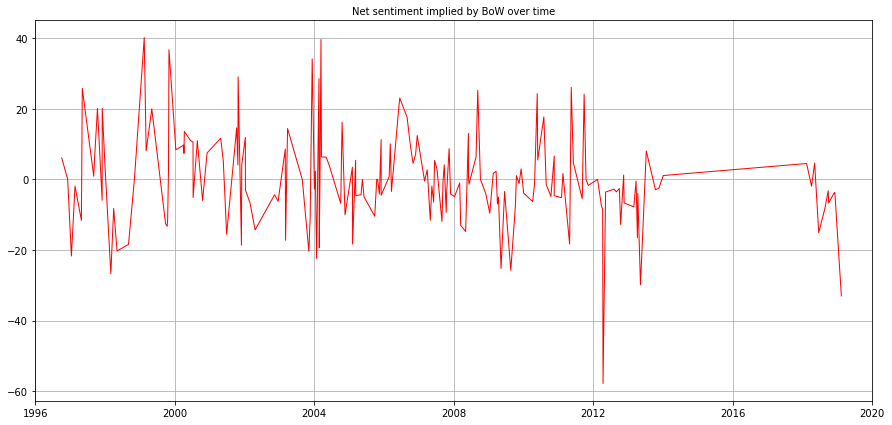

In [132]:
# Normalize data
NPositiveWordsNorm = cdict['NPositiveWords'] / cdict['wordcount'] * np.mean(cdict['wordcount'])
NNegativeWordsNorm = cdict['NNegativeWords'] / cdict['wordcount'] * np.mean(cdict['wordcount'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(cdict.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(cdict.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(cdict.index[0], 'Y')
datemax = np.datetime64(cdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


fig, ax = plt.subplots(figsize=(15,7))
ax.plot(cdict.index, NetSentimentNorm, c='red', linewidth=1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(cdict.index[0], 'Y')
datemax = np.datetime64(cdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

## Correlation between FED Interest Rate and Chair Speeches Sentiment

In [133]:
cdict['RateDecision'] = None
cdict['Rate'] = None

for i in range(len(cdict)):
    for j in range(len(fedrate_df)):
        if cdict.index[i] == fedrate_df.index[j]:
            cdict['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                cdict['RateDecision'][i] = 0
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                cdict['RateDecision'][i] = 1
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                cdict['RateDecision'][i] = -1

cdict.head(10)

,type,title,speaker,word_count,text,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords,index,RateDecision,Rate
date,,,,,,,,,,,,,,
1996-10-05,speech,"Bank supervision, regulation, and risk",Chairman Alan Greenspan,136,"While awaiting perfection, it is useful to und...",136,7,5,1.470588,"[best, assure, best, best, improved, increase,...","[risk, confines, barrier, risk, risk]",0,0,5.25
1996-12-06,speech,Social security,Chairman Alan Greenspan,253,While such evaluations are based on an uncerta...,253,6,6,0.000000,"[benefit, more, increasing, improve, growth, i...","[uncertain, under, less, difficult, down, incr...",1,0,5.25
1997-01-14,speech,Central banking and global finance,Chairman Alan Greenspan,133,"In theory, the allocation of responsibility fo...",133,2,9,-5.263158,"[higher, increased]","[risk, least, risk, risk, risk, smaller, losse...",2,0,5.25
1997-02-21,speech,Government regulation and derivative contracts,Chairman Alan Greenspan,212,In the case of the institutional off-exchange ...,212,5,6,-0.471698,"[efficiently, achieving, deliver, successful, ...","[manipulated, difficult, manipulate, failing, ...",3,0,5.25
1997-04-29,speech,G-7 economic summit meeting,Chairman Alan Greenspan,142,"In theory, the allocation of responsibility fo...",142,5,9,-2.816901,"[greater, higher, more, largest, increased]","[risk, least, risk, risk, risk, smaller, losse...",4,0,5.5
1997-05-08,speech,Current monetary policy,Chairman Alan Greenspan,144,I viewed our small increase in the federal fun...,144,12,3,6.250000,"[increase, most, growth, increased, strength, ...","[low, wrong, persistent]",5,0,5.5
1997-09-05,speech,Rules vs. discretionary monetary policy,Chairman Alan Greenspan,468,Although the ultimate goals of policy have rem...,468,10,9,0.213675,"[growth, stabilized, easy, strengthening, more...","[unanticipated, deviation, lose, difficult, di...",6,0,5.5
1997-09-12,speech,"Education, technology, and economic growth",Chairman Alan Greenspan,162,The University has made this important commitm...,162,5,3,1.234568,"[most, most, most, enhance, growth]","[confronting, fallout, obsolete]",7,0,5.5
1997-10-14,speech,Inaugural speech for economic seminar series,Chairman Alan Greenspan,123,One of the most central dynamic forces is the ...,123,7,1,4.878049,"[most, expansion, most, more, most, enhance, g...",[obsolete],8,0,5.5


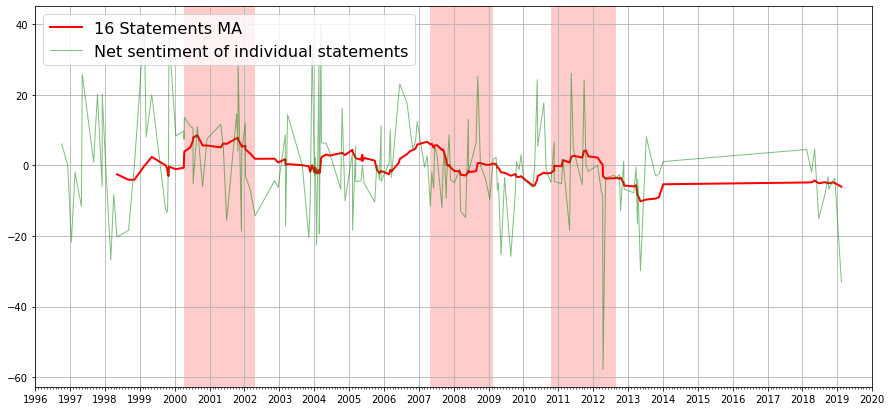

In [134]:
#Dot-com bubble
#https://en.wikipedia.org/wiki/Dot-com_bubble
DotCom = np.logical_and(cdict.index > '2000-03',
                         cdict.index < '2002-10'
                        )

#Financial crisis of 2007–2008
#https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
OhEight = np.logical_and(cdict.index > '2007-04',
                         cdict.index < '2009-03'
                        )

#European debt crisis
#https://en.wikipedia.org/wiki/European_debt_crisis
EuroDebt = np.logical_and(cdict.index > '2010-09',
                          cdict.index < '2012-09'
                          )

#2015–16 Chinese stock market turbulence
#https://en.wikipedia.org/wiki/2015%E2%80%9316_Chinese_stock_market_turbulence
Asian = np.logical_and(cdict.index > '2015-01',
                       cdict.index < '2016-06'
                       )


Recessions = np.logical_or.reduce( ( DotCom,
                                     OhEight,
                                     EuroDebt,
                                     Asian 
                                    )
                                 )

Window = 16
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(cdict.index,
         CompToMA,
         c = 'r',
         linewidth= 2)

ax.plot(cdict.index, NetSentimentNorm, 
         c = 'green',
         linewidth= 1,
         alpha = 0.5)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(cdict.index[0], 'Y')
datemax = np.datetime64(cdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)



#plt.title( str('Moving average of last ' + str(Window) + ' statements (~2 Year Window) seems to match with periods of economic uncertainty / systemic risk:'))

ax.legend([str('16 Statements MA'), 'Net sentiment of individual statements'],
           prop={'size': 16},
           loc = 2
          )

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(cdict.index, 0, 10, where = Recessions,
                facecolor='red', alpha=0.2, transform=trans)

plt.show()

In [135]:
Greenspan = np.logical_and(cdict.index > '1987-08-11',
                         cdict.index < '2006-01-31'
                        )

Bernanke = np.logical_and(cdict.index > '2006-02-01',
                         cdict.index < '2014-01-31'
                        )

Yellen = np.logical_and(cdict.index > '2014-02-03',
                          cdict.index < '2018-02-03'
                          )

Powell = np.logical_and(cdict.index > '2018-02-05',
                       cdict.index < '2022-02-05'
                       )

Speaker = np.logical_or.reduce((Greenspan, Yellen))

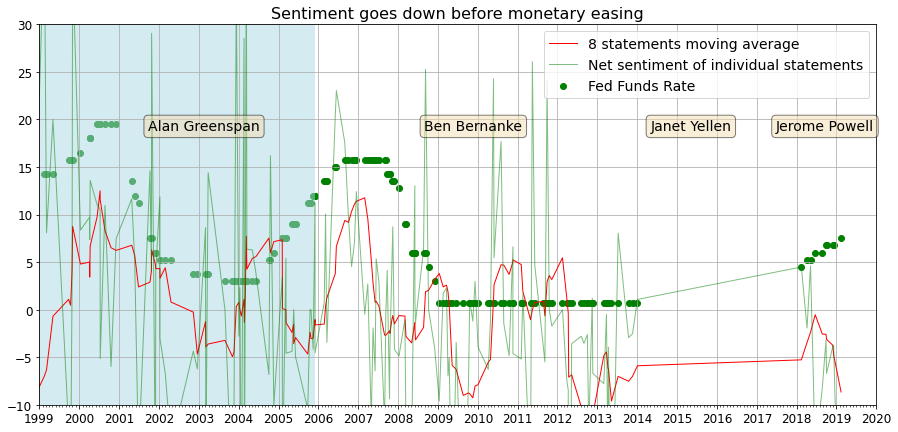

In [136]:
Window = 8
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(cdict.index, 
            cdict['Rate']*3, 
            c = 'g')

ax.plot(cdict.index,
         CompToMA,
         c = 'r',
         linewidth= 1.0)

ax.plot(cdict.index, NetSentimentNorm, 
         c = 'green',
         linewidth= 1,
         alpha = 0.5)

ax.legend([str(str(Window) + ' statements moving average') , 'Net sentiment of individual statements', 'Fed Funds Rate'],
           prop={'size': 14},
           loc = 1
           )

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(cdict.index[18], 'Y')
datemax = np.datetime64(cdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.set_ylim(-10,30)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=12)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(cdict.index, 0, 10, where = Speaker,
                facecolor='lightblue', alpha=0.5, transform=trans)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.13, 0.75, "Alan Greenspan", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.46, 0.75, "Ben Bernanke", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.73, 0.75, "Janet Yellen", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.88, 0.75, "Jerome Powell", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

arrow_style = dict(facecolor='black', edgecolor='white', shrink=0.05)

plt.title('Sentiment goes down before monetary easing', fontsize=16)

plt.show()

In [137]:
cd ../content/drive/MyDrive/FINA4350/FOMC/

[Errno 2] No such file or directory: '../content/drive/MyDrive/FINA4350/FOMC/'
/content/drive/.shortcut-targets-by-id/1jWSL-7-Ar9s84ZTFZlpGEpDQOBrS9Dcu/FINA4350/FOMC


# Speeches of FED Vice-Chairs and Correlation with FED Interest Rate Decision

In [138]:
import pickle
f = open('vicechair_speech_keyword.pickle', 'rb')   
vdict = pickle.load(f)        
f.close()  
 
vdict.text = vdict.text.str.replace('\[SECTION\]',' ')
vdict.text = vdict.text.str.replace('\\','')
vdict = vdict.reset_index(drop=True)
vdict

,type,date,title,speaker,word_count,text
0,speech,1997-03-13,Sustaining CRA's success,Vice Chair Alice M. Rivlin,152,Steady growth with low inflation and low inter...
1,speech,1997-04-04,The challenges of macroeconomic policy,Vice Chair Alice M. Rivlin,342,"At the moment, as a relatively new governor of..."
2,speech,1998-05-12,Commencement address,Vice Chair Alice M. Rivlin,156,Were we smart or lucky? Some of each. Everyo...
3,speech,1998-06-18,Renewed confidence and vitality of the U.S. ec...,Vice Chair Alice M. Rivlin,98,"One example, is the series of Federal Reserve ..."
4,speech,1998-10-22,The world economy,Vice Chair Alice M. Rivlin,398,"Indeed, the Federal Reserve was concerned enou..."
...,...,...,...,...,...,...
177,speech,2020-08-31,The Federal Reserveâs New Monetary Policy Fr...,Vice Chair Richard H. Clarida,1607,Perhaps the most significant change since 2012...
178,speech,2020-09-23,Optimism in the Time of COVID,Vice Chair for Supervision Randal K. Quarles,298,All of these facts lead me to believe the mome...
179,speech,2020-10-14,U.S. Economic Outlook and Monetary Policy,Vice Chair Richard H. Clarida,730,Current Economic Situation and OutlookIn the f...
180,speech,2020-10-15,What Happened? What Have We Learned From It? L...,Vice Chair for Supervision Randal K. Quarles,185,"It seems like a very long time ago, but early ..."


In [139]:
gov = set(vdict.speaker)

for i in gov:
  temp  = vdict.loc[vdict["speaker"]==i, 'date']
  temp = temp.reset_index(drop=True)
  print(i,temp[0],temp[len(temp)-1])

Vice Chairman Roger W. Ferguson, Jr. 1999-10-06 00:00:00 2006-04-17 00:00:00
Vice Chair Alice M. Rivlin 1997-03-13 00:00:00 1999-06-01 00:00:00
Vice Chairman Richard H. Clarida 2018-10-25 00:00:00 2019-01-10 00:00:00
Vice Chair Richard H. Clarida 2019-02-22 00:00:00 2020-10-19 00:00:00
Vice Chair for Supervision Randal K. Quarles 2019-03-29 00:00:00 2020-10-15 00:00:00
Vice Chair Janet L. Yellen 2010-12-01 00:00:00 2013-04-16 00:00:00
Vice Chairman Donald L. Kohn 2006-07-06 00:00:00 2010-05-13 00:00:00
Vice Chairman Stanley Fischer 2014-07-10 00:00:00 2017-09-28 00:00:00
Vice Chair for Supervision and Chair of the Financial Stability Board Randal K. Quarles 2019-04-10 00:00:00 2019-04-10 00:00:00
Vice Chairman Roger W. Ferguson, Jr 2002-10-16 00:00:00 2003-02-12 00:00:00
Vice Chairman for Supervision Randal K. Quarles 2018-02-22 00:00:00 2019-02-22 00:00:00


In [140]:
temp = [tone_count_with_negation_check(lmdict,x) for x in vdict.text]
temp = pd.DataFrame(temp)

vdict['wordcount'] = temp.iloc[:,0].values
vdict['NPositiveWords'] = temp.iloc[:,1].values
vdict['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
vdict['sentiment'] = (vdict['NPositiveWords'] - vdict['NNegativeWords']) / vdict['wordcount'] * 100

vdict['Poswords'] = temp.iloc[:,3].values
vdict['Negwords'] = temp.iloc[:,4].values

In [141]:
vdict['index'] = range(0, len(vdict))

vdict.set_index('date', inplace=True)
vdict.head()

,type,title,speaker,word_count,text,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords,index
date,,,,,,,,,,,,
1997-03-13,speech,Sustaining CRA's success,Vice Chair Alice M. Rivlin,152,Steady growth with low inflation and low inter...,152,10,6,2.631579,"[growth, most, growth, stable, enable, more, a...","[low, low, less, deficit, downward, down]",0
1997-04-04,speech,The challenges of macroeconomic policy,Vice Chair Alice M. Rivlin,342,"At the moment, as a relatively new governor of...",342,13,6,2.046784,"[growth, high, high, desired, best, most, cert...","[popular (with negation), exceed (with negatio...",1
1998-05-12,speech,Commencement address,Vice Chair Alice M. Rivlin,156,Were we smart or lucky? Some of each. Everyo...,156,11,7,2.564103,"[better, success, good, good, growth, strong, ...","[ideal (with negation), failure, mistakes, bad...",2
1998-06-18,speech,Renewed confidence and vitality of the U.S. ec...,Vice Chair Alice M. Rivlin,98,"One example, is the series of Federal Reserve ...",98,1,2,-1.020408,[enthusiasm],"[slowing, enthusiasm (with negation)]",3
1998-10-22,speech,The world economy,Vice Chair Alice M. Rivlin,398,"Indeed, the Federal Reserve was concerned enou...",398,12,38,-6.532663,"[growth, good, high, most, growth, high, stron...","[concerned, crisis, slower, cut, falling, low,...",4


## Sentiment Plots

### Positive and Negative Words

1997 2021


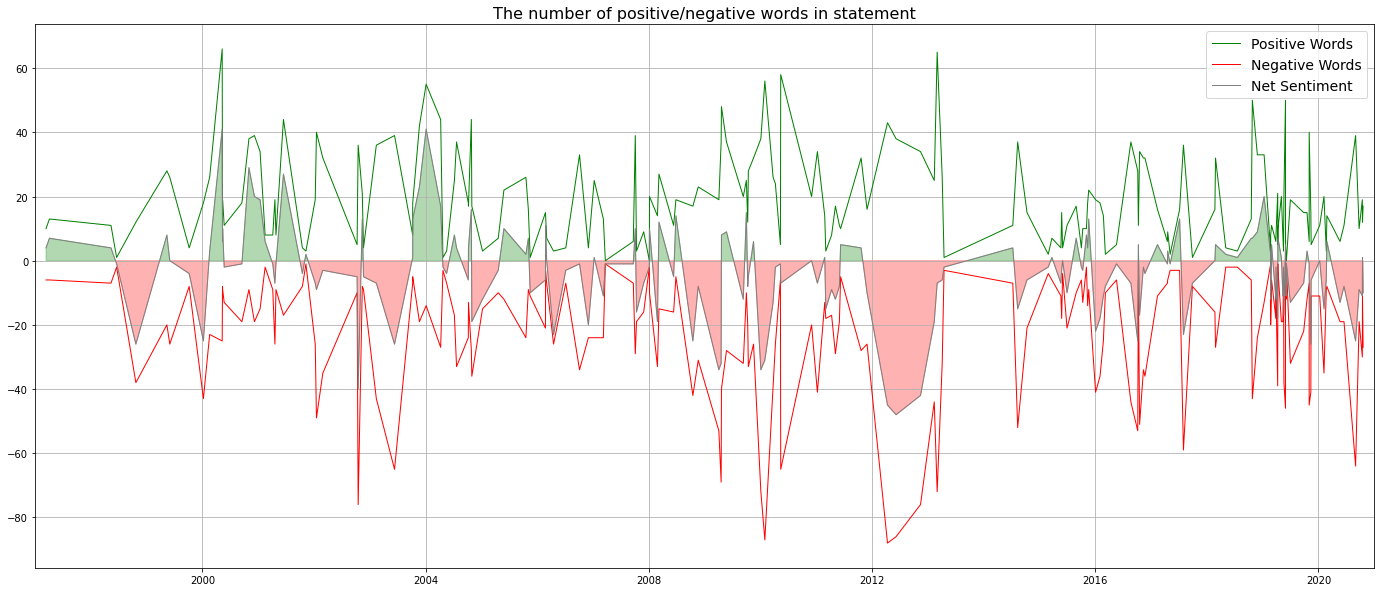

<Figure size 7200x7200 with 0 Axes>

In [142]:
NetSentiment = vdict['NPositiveWords'] - vdict['NNegativeWords']

fig, ax = plt.subplots(figsize=(24,10))

plt.plot(vdict.index, vdict['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(vdict.index, vdict['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(vdict.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)
plt.figure(figsize=(100,100))


ax.fill_between(vdict.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3,
                 interpolate=True)
ax.fill_between(vdict.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3,
                 interpolate=True)



# ## format the ticks
# # round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(vdict.index[0], 'Y')

datemax = np.datetime64(vdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
print(datemin,datemax)

# # format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()

### Net Sentiment

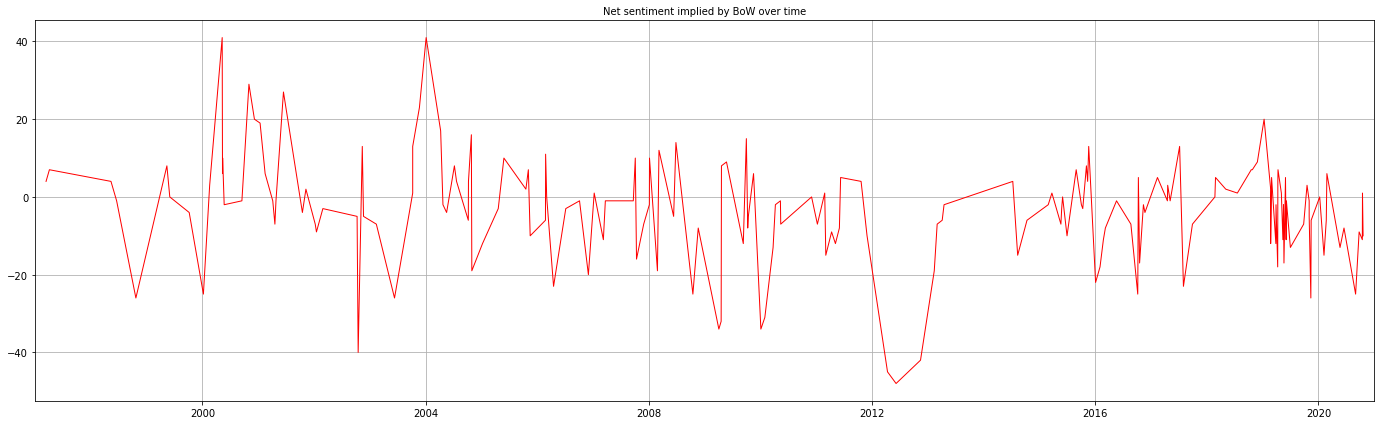

In [143]:
NetSentiment = vdict['NPositiveWords'] - vdict['NNegativeWords']

fig, ax = plt.subplots(figsize=(24,7))

ax.plot(vdict.index, NetSentiment, 
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(vdict.index[0], 'Y')
datemax = np.datetime64(vdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

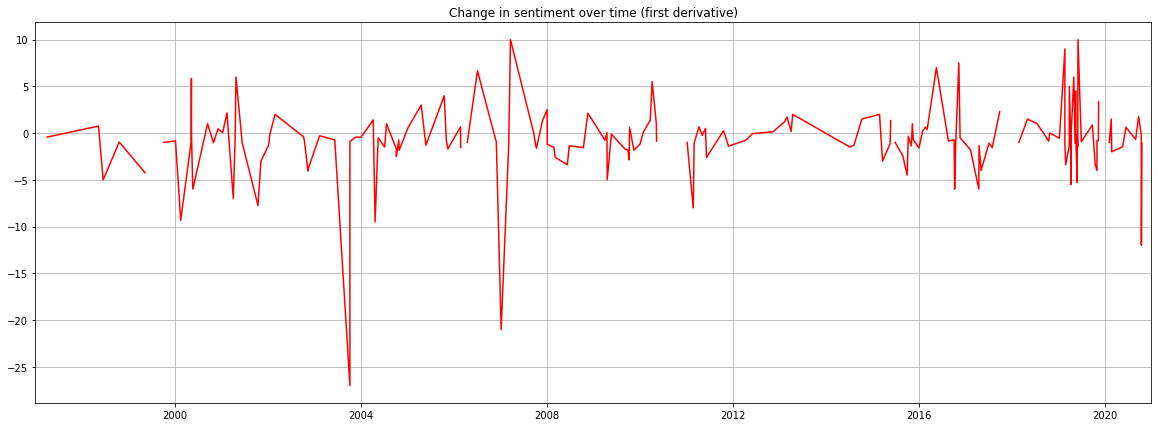

In [144]:
firstderivative = (NetSentiment.shift(1) - NetSentiment) / NetSentiment

fig, ax = plt.subplots(figsize=(20,7))

ax.plot(vdict.index, firstderivative, 
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.
datemin = np.datetime64(vdict.index[0], 'Y')
datemax = np.datetime64(vdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

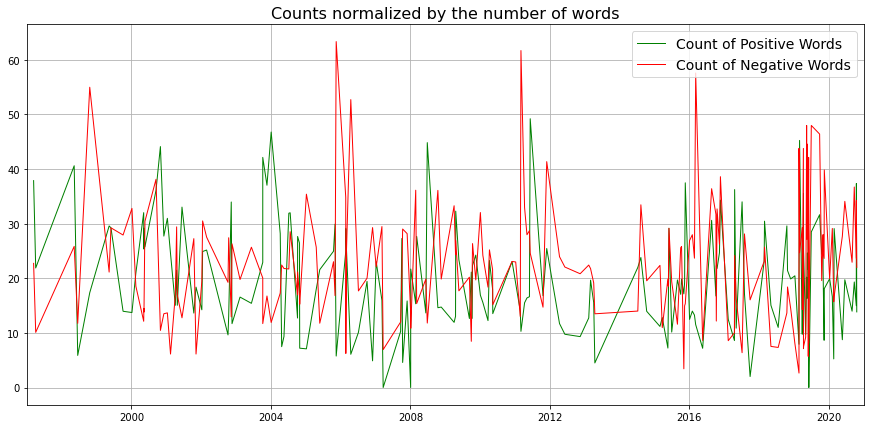

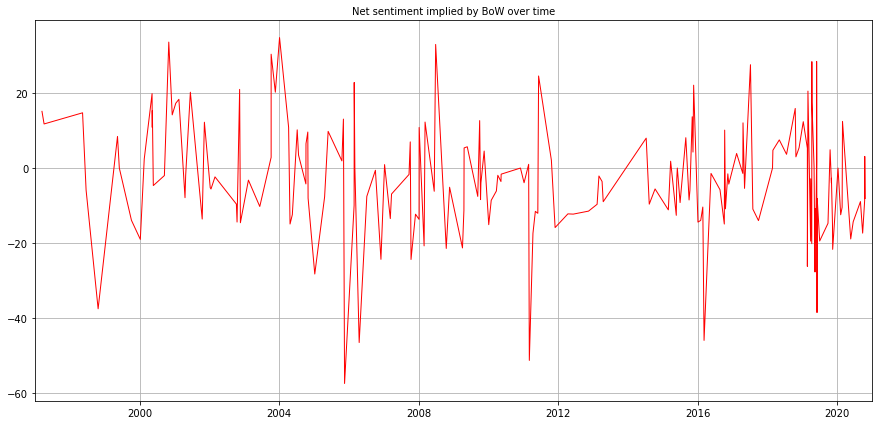

In [145]:
# Normalize data
NPositiveWordsNorm = vdict['NPositiveWords'] / vdict['wordcount'] * np.mean(vdict['wordcount'])
NNegativeWordsNorm = vdict['NNegativeWords'] / vdict['wordcount'] * np.mean(vdict['wordcount'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(vdict.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(vdict.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(vdict.index[0], 'Y')
datemax = np.datetime64(vdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


fig, ax = plt.subplots(figsize=(15,7))
ax.plot(vdict.index, NetSentimentNorm, c='red', linewidth=1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(vdict.index[0], 'Y')
datemax = np.datetime64(vdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

## Correlation between FED Interest Rate Decision and Vice-Chair Speeches Sentiment

In [148]:
vdict['RateDecision'] = None
vdict['Rate'] = None

for i in range(len(vdict)):
    for j in range(len(fedrate_df)):
        if vdict.index[i] == fedrate_df.index[j]:
            vdict['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                vdict['RateDecision'][i] = 0
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                vdict['RateDecision'][i] = 1
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                vdict['RateDecision'][i] = -1

vdict.head(10)

,type,title,speaker,word_count,text,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords,index,RateDecision,Rate
date,,,,,,,,,,,,,,
1997-03-13,speech,Sustaining CRA's success,Vice Chair Alice M. Rivlin,152,Steady growth with low inflation and low inter...,152,10,6,2.631579,"[growth, most, growth, stable, enable, more, a...","[low, low, less, deficit, downward, down]",0,0,5.25
1997-04-04,speech,The challenges of macroeconomic policy,Vice Chair Alice M. Rivlin,342,"At the moment, as a relatively new governor of...",342,13,6,2.046784,"[growth, high, high, desired, best, most, cert...","[popular (with negation), exceed (with negatio...",1,0,5.5
1998-05-12,speech,Commencement address,Vice Chair Alice M. Rivlin,156,Were we smart or lucky? Some of each. Everyo...,156,11,7,2.564103,"[better, success, good, good, growth, strong, ...","[ideal (with negation), failure, mistakes, bad...",2,0,5.5
1998-06-18,speech,Renewed confidence and vitality of the U.S. ec...,Vice Chair Alice M. Rivlin,98,"One example, is the series of Federal Reserve ...",98,1,2,-1.020408,[enthusiasm],"[slowing, enthusiasm (with negation)]",3,0,5.5
1998-10-22,speech,The world economy,Vice Chair Alice M. Rivlin,398,"Indeed, the Federal Reserve was concerned enou...",398,12,38,-6.532663,"[growth, good, high, most, growth, high, stron...","[concerned, crisis, slower, cut, falling, low,...",4,0,5
1999-05-13,speech,On sustaining U.S. economic growth,Vice Chair Alice M. Rivlin,545,What do we mean when we say the economy is per...,545,28,20,1.467890,"[growth, up, growing, expansion, grew, grown, ...","[unemployment, negative, crisis, unemployment,...",5,0,4.75
1999-06-01,speech,Dilemmas facing United States policymakers,Vice Chair Alice M. Rivlin,512,"The sustained coexistence of strong growth, ti...",512,26,26,0.000000,"[strong, growth, benefiting, easily, more, ena...","[strong, low, question, less, risk, low, risk,...",6,0,4.75
1999-10-06,speech,Year 2000: Eighty-six days and counting,"Vice Chairman Roger W. Ferguson, Jr.",165,Even with the flexibility provided by these to...,165,4,8,-2.424242,"[more, increased, rise, high]","[difficult, volatile, unexpected, shortfall, u...",7,0,5.25
2000-01-07,speech,Tale of two continents: A comparison of Asian ...,"Vice Chairman Roger W. Ferguson, Jr.",755,"Ironically, several of Brazils neighbors have ...",755,18,43,-3.311258,"[successfully, high, strong, growth, stronger,...","[worse, defended, suffered, decline, defend, u...",8,0,5.5


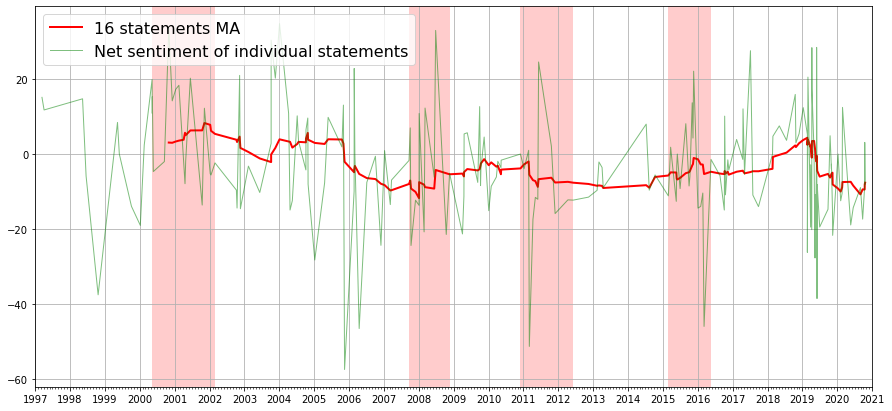

In [149]:
#Dot-com bubble
#https://en.wikipedia.org/wiki/Dot-com_bubble
DotCom = np.logical_and(vdict.index > '2000-03',
                         vdict.index < '2002-10'
                        )

#Financial crisis of 2007–2008
#https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
OhEight = np.logical_and(vdict.index > '2007-04',
                         vdict.index < '2009-03'
                        )

#European debt crisis
#https://en.wikipedia.org/wiki/European_debt_crisis
EuroDebt = np.logical_and(vdict.index > '2010-09',
                          vdict.index < '2012-09'
                          )

#2015–16 Chinese stock market turbulence
#https://en.wikipedia.org/wiki/2015%E2%80%9316_Chinese_stock_market_turbulence
Asian = np.logical_and(vdict.index > '2015-01',
                       vdict.index < '2016-06'
                       )


Recessions = np.logical_or.reduce( ( DotCom,
                                     OhEight,
                                     EuroDebt,
                                     Asian 
                                    )
                                 )

Window = 16
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(vdict.index,
         CompToMA,
         c = 'r',
         linewidth= 2)

ax.plot(vdict.index, NetSentimentNorm, 
         c = 'green',
         linewidth= 1,
         alpha = 0.5)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(vdict.index[0], 'Y')
datemax = np.datetime64(vdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)



ax.legend([str('16 statements MA'), 'Net sentiment of individual statements'],
           prop={'size': 16},
           loc = 2
          )

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(vdict.index, 0, 10, where = Recessions,
                facecolor='red', alpha=0.2, transform=trans)

plt.show()

In [151]:
Yellen=np.logical_and(vdict.index> '2010-12-01', vdict.index<' 2013-04-16') 
Clarida=np.logical_and(vdict.index>  '2018-10-25', vdict.index<  '2020-10-19')
Ferguson=np.logical_and(vdict.index>  '1999-10-06', vdict.index< '2006-04-17' )
Quarles=np.logical_and(vdict.index> '2018-02-22', vdict.index<  '2019-02-22 ')
Fischer=np.logical_and(vdict.index> '2014-07-10' , vdict.index< '2017-09-28')
Rivlin=np.logical_and(vdict.index>  '1997-03-13' , vdict.index<'1999-06-01 ')
Kohn=np.logical_and(vdict.index> ' 2006-07-06'  , vdict.index<'2010-05-13')
Speaker = np.logical_or.reduce((Rivlin, Clarida))


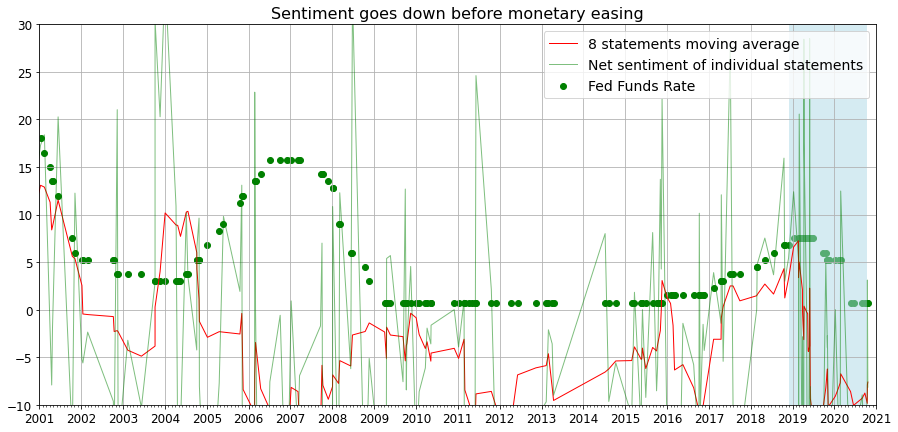

In [152]:
Window = 8
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(vdict.index, 
            vdict['Rate']*3, 
            c = 'g')

ax.plot(vdict.index,
         CompToMA,
         c = 'r',
         linewidth= 1.0)

ax.plot(vdict.index, NetSentimentNorm, 
         c = 'green',
         linewidth= 1,
         alpha = 0.5)

ax.legend([str(str(Window) + ' statements moving average') , 'Net sentiment of individual statements', 'Fed Funds Rate'],
           prop={'size': 14},
           loc = 1
           )

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(vdict.index[18], 'Y')
datemax = np.datetime64(vdict.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
ax.set_ylim(-10,30)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=12)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(vdict.index, 0, 10, where = Speaker,
                facecolor='lightblue', alpha=0.5, transform=trans)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

arrow_style = dict(facecolor='black', edgecolor='white', shrink=0.05)

plt.title('Sentiment goes down before monetary easing', fontsize=16)

plt.show()